In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [10]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

# if (!requireNamespace("BiocManager", quietly=TRUE)) 
#     install.packages("BiocManager") 

# BiocManager::install("ComplexHeatmap")

In [3]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '050625'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(gridtext)
library(IRanges)
library(ComplexHeatmap)
library(circlize)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_050225.xlsx")) 

In [4]:
head(full_df)
dim(full_df)

,SampleID,HAWC_ID,Study,Metric,Sample,Class,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Li,Li,1.794436
2,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,K,K,60000.000000
3,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Ca,Ca,2800.000000
4,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Cd,Cd,25.000000
5,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Fe,Fe,1400.000000
6,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Mn,Mn,280.000000


[1] 727   9

This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [5]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    # removing outliers
    group_by(Metric) %>%
    group_split

vol_df = split_df[[1]]
weight_df = split_df[[2]]

head(vol_df)

SampleID,HAWC_ID,Study,Metric,Sample,Class,DTXSID,Name,Value
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Li,Li,1.794436
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,K,K,60000.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Ca,Ca,2800.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Cd,Cd,25.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Fe,Fe,1400.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Mn,Mn,280.000000


In [6]:
`%notin%` <- Negate(`%in%`) 
wider_vol_df = vol_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_weight_df = weight_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_vol_df)

,HAWC_ID,Study,Metric,Sample,Li,K,Ca,Cd,Fe,Mn,⋯,DTXSID0023909,DTXSID8024153,DTXSID4047753,DTXSID3023764,DTXSID3024289,DTXSID3023845,DTXSID8024105,DTXSID7058701,DTXSID3039242,DTXSID7021360
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
993956_WS,993956,Ihantola et al. 2022,Volume,WS,1.794436,60000.00,2800.00,25.0000,1400.000,280.000,⋯,4386.193,606.0000,162.0000,562.0000,2070.000,78000.42,51887.57,80.00000,382000,38800
266980_WS,266980,Stockfelt et al. 2012,Volume,WS,1.773940,9250.00,53617.09,268.4627,6525.903,3770.318,⋯,13.750,31.5000,3.3000,441.4371,1448.445,58500.54,19847.08,33.01373,27000,22500
1263480_WS,1263480,Burnet et al. 1990,Volume,WS,2.918942,1593166.67,374250.00,1833.3333,25791.667,11708.333,⋯,79458.333,12977.8552,390.9083,504500.0000,1269583.333,10961166.67,1219541.67,197.31947,111230625,39687250
1263484_WS,1263484,Leese et al. 1989,Volume,WS,2.918942,1730140.00,61230.00,3480.0000,38670.000,15885.000,⋯,20000.000,20000.0000,390.9083,229846.6845,555000.000,1950000.00,765000.00,197.31947,35722210,18670964
885041_WS,885041,Ihantola et al. 2020,Volume,WS,4.375000,99550.00,3710.00,152.0000,1088.500,133.000,⋯,12541.060,2250.0000,1320.0000,10550.0000,25500.000,574946.98,87032.81,435.00000,14692921,6377825
1070627_WF,1070627,Siregar et al. 2022,Volume,WF,0.300000,786.75,982.65,5.4500,771.000,35.550,⋯,9557.920,576.4716,529.9661,28471.2445,20645.472,168112.08,64082.91,195.59400,9150490,5187882


# Principal Component Analysis (PCA)

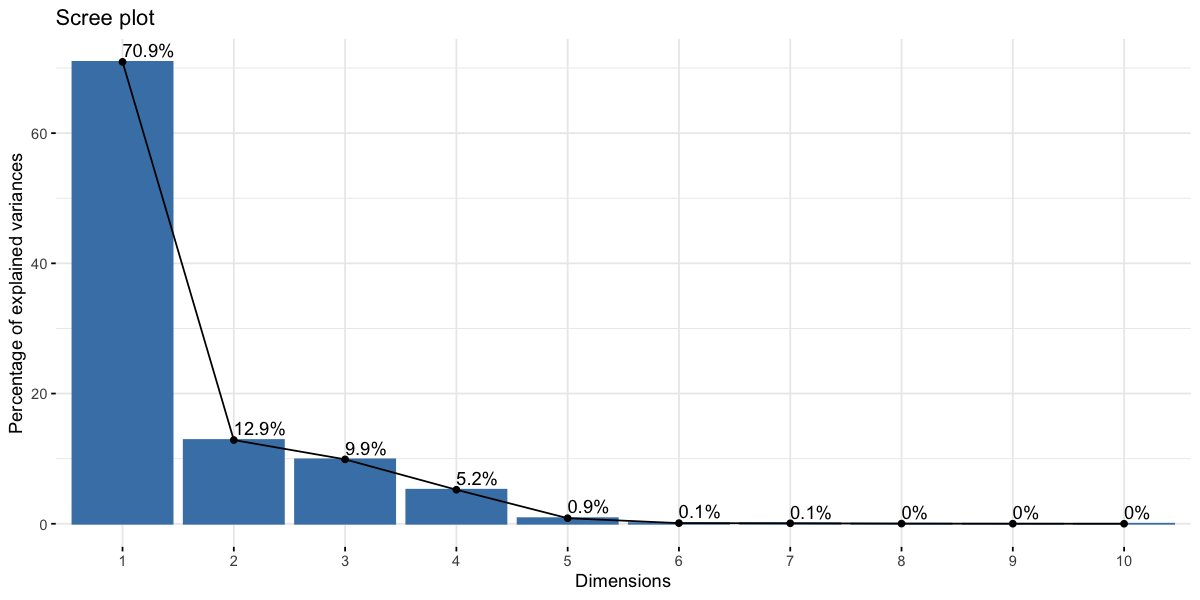

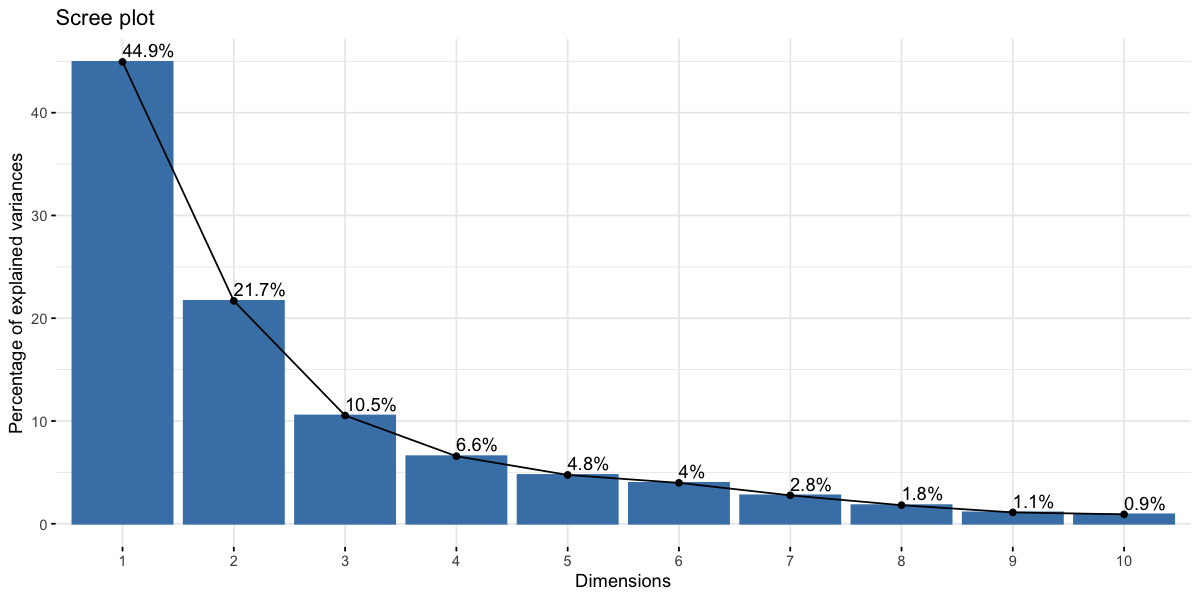

In [7]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(vol_pca, addlabels = TRUE)
fviz_eig(weight_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [8]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
vol_outliers = outlier_detection(vol_pca)
weight_outliers = outlier_detection(weight_pca)

In [9]:
# getting length
length(vol_outliers)
length(weight_outliers)

[1] 0

[1] 0

There were no outliers.

In [10]:
# creating 1 df with eigenvectors and metadata
vol_pca_df = data.frame(vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
weight_pca_df = data.frame(weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 

more_data_df = rbind(wider_vol_df[,1:4] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_weight_df[,1:4] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(vol_pca_df, weight_pca_df), 
                                             more_data_df) %>%
    # cleaning variable names here
    mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Study,Metric,Sample
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,993956_WS,-2.720965,-0.1757834,993956,Ihantola et al. 2022,Volume,Woodsmoke
2,266980_WS,-2.460841,0.3545670,266980,Stockfelt et al. 2012,Volume,Woodsmoke
3,1263480_WS,8.363102,-2.9330343,1263480,Burnet et al. 1990,Volume,Woodsmoke
4,1263484_WS,3.942663,3.1904791,1263484,Leese et al. 1989,Volume,Woodsmoke
5,885041_WS,-1.951610,-1.4802008,885041,Ihantola et al. 2020,Volume,Woodsmoke
6,1070627_WF,-2.364628,-0.7508605,1070627,Siregar et al. 2022,Volume,Wildfire


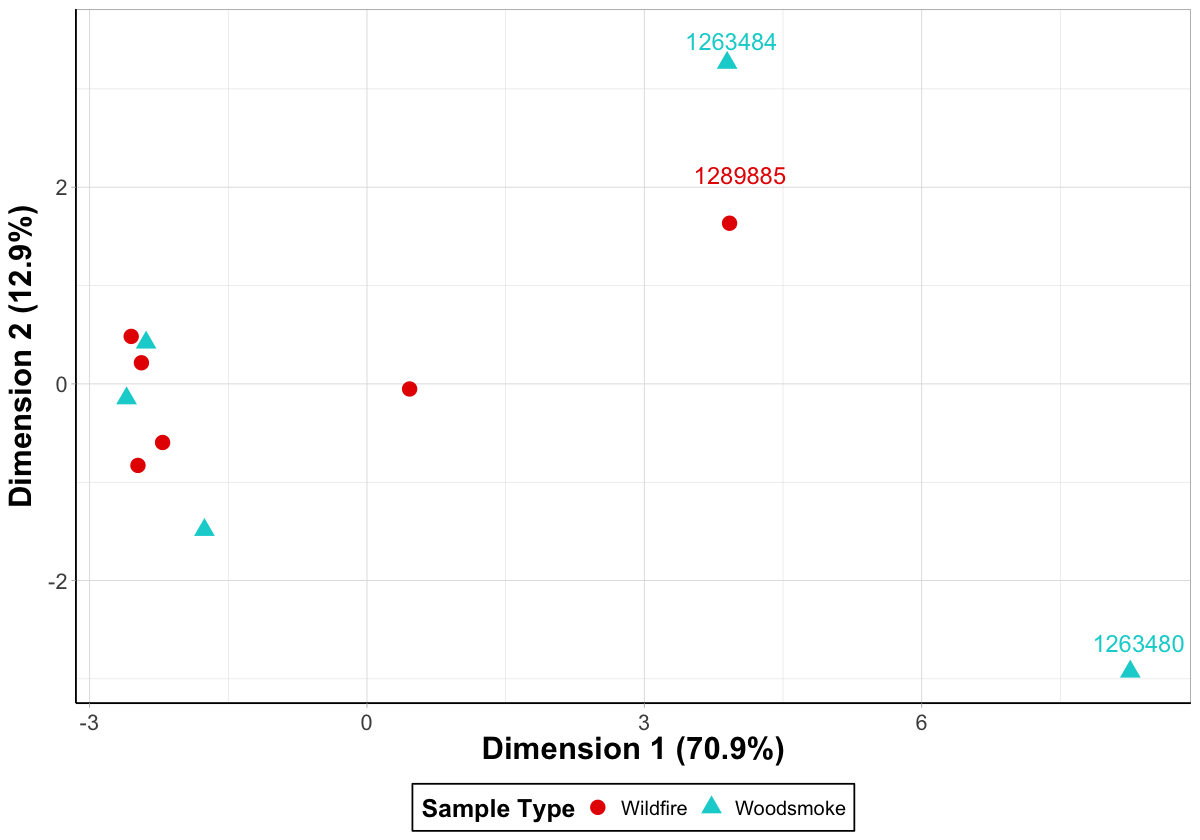

In [11]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_pca_figure = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume'), aes(x = PC1, y = PC2, color = Sample, shape = Sample),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', PC1 > 3), 
                  aes(x = PC1, y = PC2, color = Sample, label = HAWC_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (70.9%)', y = 'Dimension 2 (12.9%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

vol_pca_figure

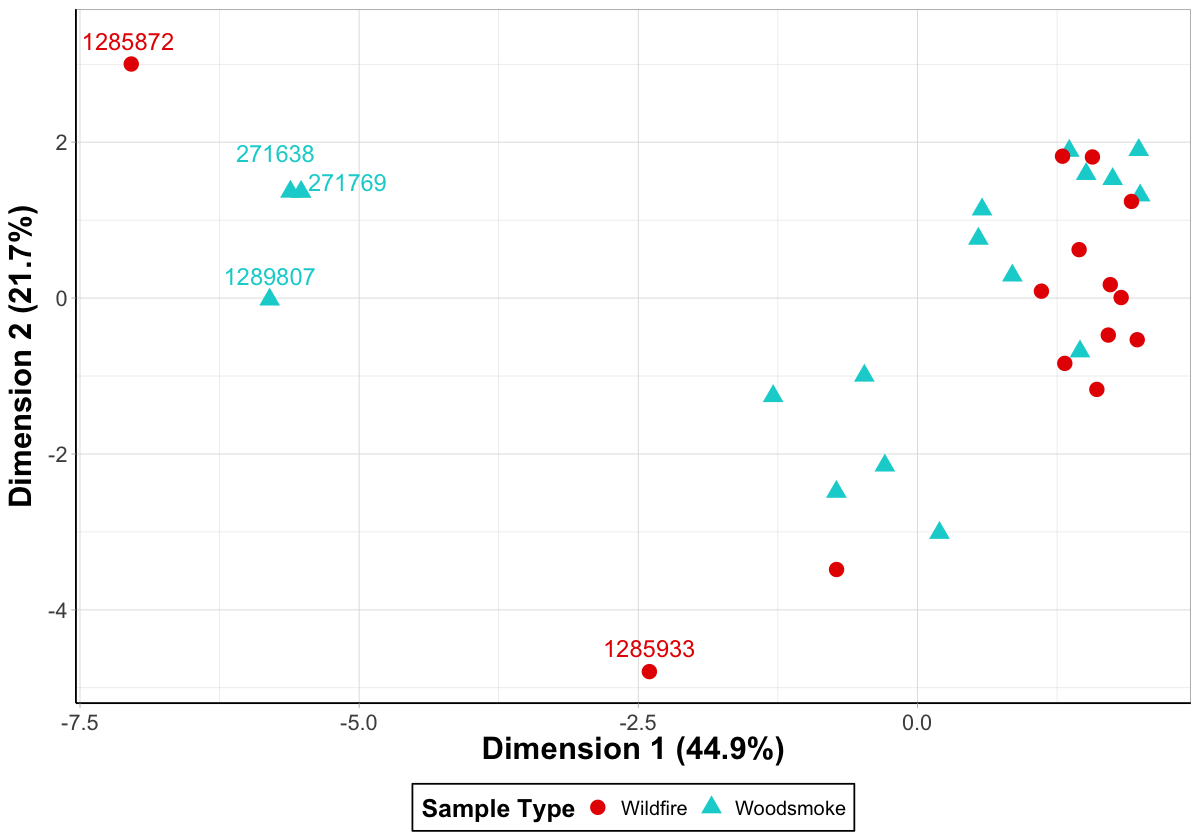

In [12]:
weight_pca_figure = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight'), 
       aes(x = PC1, y = PC2, color = Sample, shape = Sample)) + 
  geom_point(size = 4, position = position_jitter(w = 0.08)) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', PC1 < -2.4), 
                  aes(x = PC1, y = PC2, color = Sample, label = HAWC_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (44.9%)', y = 'Dimension 2 (21.7%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

weight_pca_figure

# Heatmaps

In [13]:
annotation_vol_col_df = unique(vol_df[,c(6,8)]) %>%
    column_to_rownames(var = "Name")
annotation_vol_row_df = unique(vol_df[,c(2,5)]) %>%
    column_to_rownames(var = "HAWC_ID") %>%
     mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))
annotation_weight_col_df = unique(weight_df[,c(6,8)]) %>%
    column_to_rownames(var = "Name")
annotation_weight_row_df = unique(weight_df[,c(2,5)]) %>%
    column_to_rownames(var = "HAWC_ID") %>%
     mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(annotation_vol_col_df)
head(annotation_vol_row_df)

,Class
,<chr>
Li,Metal
K,Metal
Ca,Metal
Cd,Metal
Fe,Metal
Mn,Metal


,Sample
,<chr>
993956,Woodsmoke
266980,Woodsmoke
1263480,Woodsmoke
1263484,Woodsmoke
885041,Woodsmoke
1070627,Wildfire


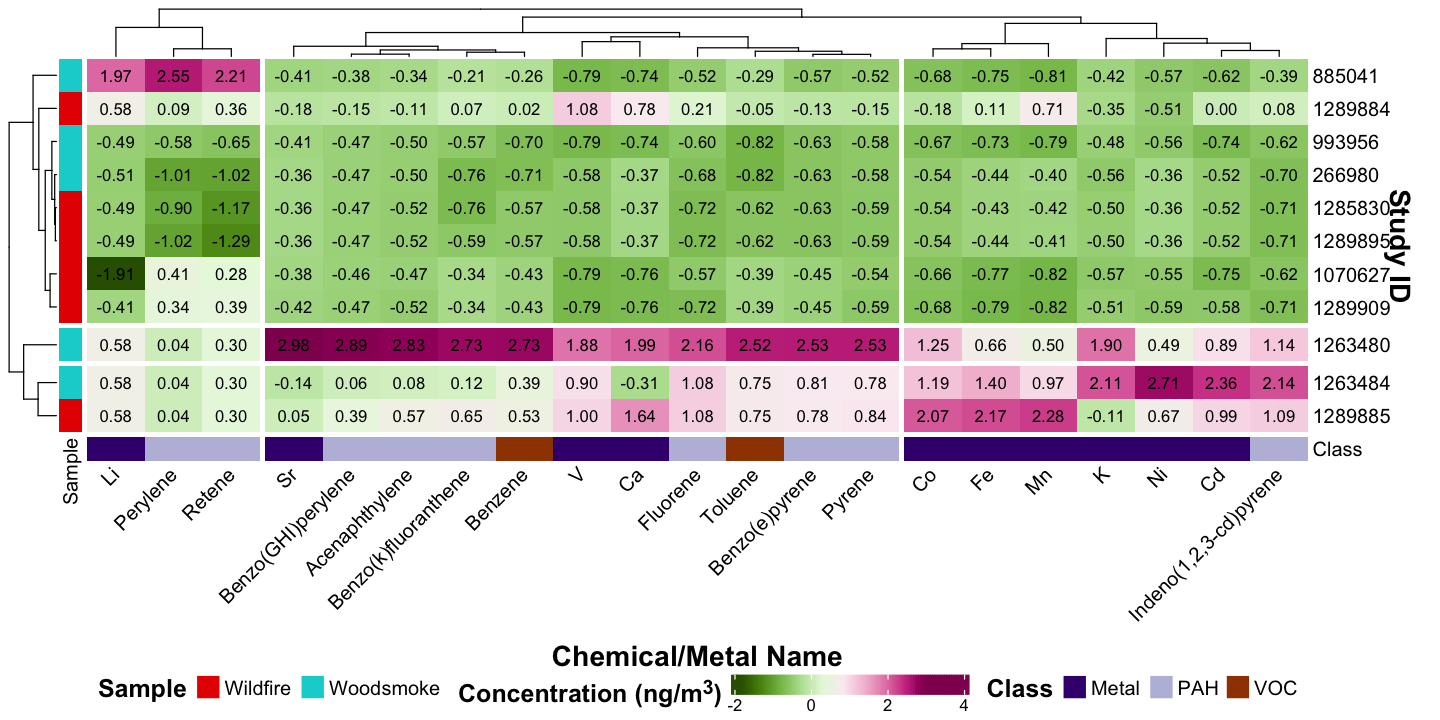

In [28]:
options(repr.plot.width=12, repr.plot.height=6) #changing size
fall_colors = rev(palette(hcl.colors(10, "PiYG")))

wider_vol_df = vol_df %>%
    select(-c("DTXSID", "Class")) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "HAWC_ID") 

vol_map = Heatmap(scale(wider_vol_df[,5:ncol(wider_vol_df)]), 
         # legend title
         heatmap_legend_param = list(title = gt_render("Concentration (ng/m<sup>3</sup>)"),
                      title_position = "leftcenter", direction = "horizontal", legend_width = unit(5, "cm"), 
                      title_gp = gpar(fontsize = 15, fontface = "bold")),       
         # adding axes titles
         column_title = "Chemical/Metal Name", column_title_side = "bottom", 
         column_title_gp = gpar(fontsize = 17, fontface = "bold"),
         row_title = "Study ID", row_title_rot = 270, row_title_side = 'right',
         row_title_gp = gpar(fontsize = 17, fontface = "bold"),
         # adding in annotation (additional data)
         bottom_annotation = HeatmapAnnotation(df = annotation_vol_col_df, 
                col = list(Class = c(Metal = "#3f007d", PAH = "#bcbddc", VOC = "#9E4200")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         left_annotation = rowAnnotation(df = annotation_vol_row_df, 
                col = list(Sample = c(Wildfire = "#e60000", Woodsmoke = "#00d2d2")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         column_names_rot = 45, 
         col = fall_colors,
         # adding numbers to cells
         cell_fun = function(j, i, x, y, width, height, fill) {
         grid.text(sprintf("%.2f", scale(wider_vol_df[,5:ncol(wider_vol_df)])[i, j]), x, y, gp = gpar(fontsize = 10))}, 
         # adds a break bewtween the largest clusters
         row_split = 3, column_split = 3)


vol_map_final = draw(vol_map, merge_legend = TRUE, heatmap_legend_side = "bottom", 
    annotation_legend_side = "bottom")
vol_map_final

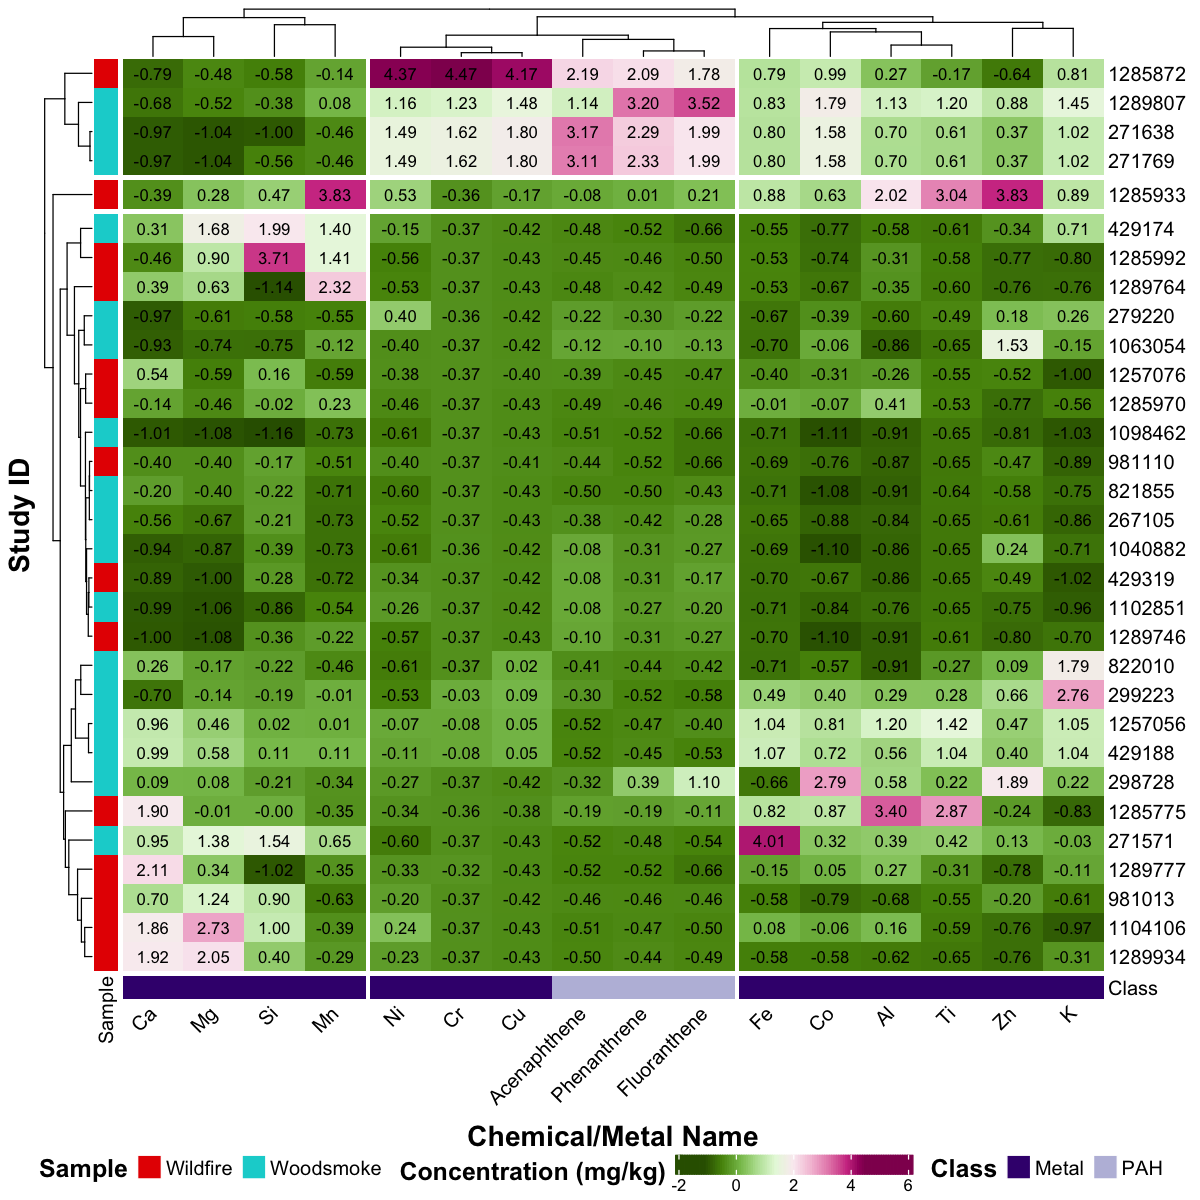

In [16]:
options(repr.plot.width=10, repr.plot.height=10) #changing size
wider_weight_df = weight_df %>%
    select(-c("DTXSID", "Class")) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "HAWC_ID") 

weight_map = Heatmap(scale(wider_weight_df[,5:ncol(wider_weight_df)]), 
         # legend title
         heatmap_legend_param = list(title = gt_render("Concentration (mg/kg)"),
                      title_position = "leftcenter", direction = "horizontal", legend_width = unit(5, "cm"), 
                      title_gp = gpar(fontsize = 15, fontface = "bold")),       
         # adding axes titles
         column_title = "Chemical/Metal Name", column_title_side = "bottom", 
         column_title_gp = gpar(fontsize = 17, fontface = "bold"),
         row_title = "Study ID", row_title_rot = 90,
         row_title_gp = gpar(fontsize = 17, fontface = "bold"),
         # adding in annotation (additional data)
         bottom_annotation = HeatmapAnnotation(df = annotation_weight_col_df, 
                col = list(Class = c(Metal = "#3f007d", PAH = "#bcbddc", VOC = "#9E4200")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         left_annotation = rowAnnotation(df = annotation_weight_row_df, 
                col = list(Sample = c(Wildfire = "#e60000", Woodsmoke = "#00d2d2")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         column_names_rot = 45, 
         col = fall_colors,
         # adding numbers to cells
         cell_fun = function(j, i, x, y, width, height, fill) {
         grid.text(sprintf("%.2f", scale(wider_weight_df[,5:ncol(wider_weight_df)])[i, j]), x, y, gp = gpar(fontsize = 10))}, 
         # adds a break bewtween the largest clusters
         row_split = 3, column_split = 3)


weight_map_final = draw(weight_map, merge_legend = TRUE, heatmap_legend_side = "bottom", 
    annotation_legend_side = "bottom")
weight_map_final

## Top Metal or Chemical Contributors to PCA

In [22]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

In [23]:
# extracting chemical/metal contributions
get_contributions = function(pca_object, class){
    # ADD WORDS

    # get pca object that contains contributions
    get_pca = get_pca_var(pca_object)
    contrib_df = data.frame(get_pca$cos2)
    
    contrib_vector = c()
    for (i in 1:length(contrib_df$Dim.1)){
        
    contrib = ((get_pca$cos2[i,1] + get_pca$cos2[i,2]) * 100)/(sum(get_pca$cos2[,1]) + sum(get_pca$cos2[,2]))
    contrib_vector = c(contrib_vector, contrib)
        
    }
    
    contrib_df = data.frame(Variable = rownames(get_pca$cos2), Contribution = contrib_vector) %>%
        arrange(-Contribution) %>%
        # creating a new col to dictate colors
        mutate(Significance = ifelse(Contribution > mean(Contribution), "Yes", "No"))

    return(contrib_df)
}

# calling fn
vol_contrib_df = get_contributions(vol_pca)
weight_contrib_df = get_contributions(weight_pca)

head(vol_contrib_df)

,Variable,Contribution,Significance
,<chr>,<dbl>,<chr>
1,Benzene,5.939976,Yes
2,Benzo(k)fluoranthene,5.931782,Yes
3,Fluorene,5.929514,Yes
4,Pyrene,5.897095,Yes
5,Toluene,5.894570,Yes
6,Benzo(e)pyrene,5.886419,Yes


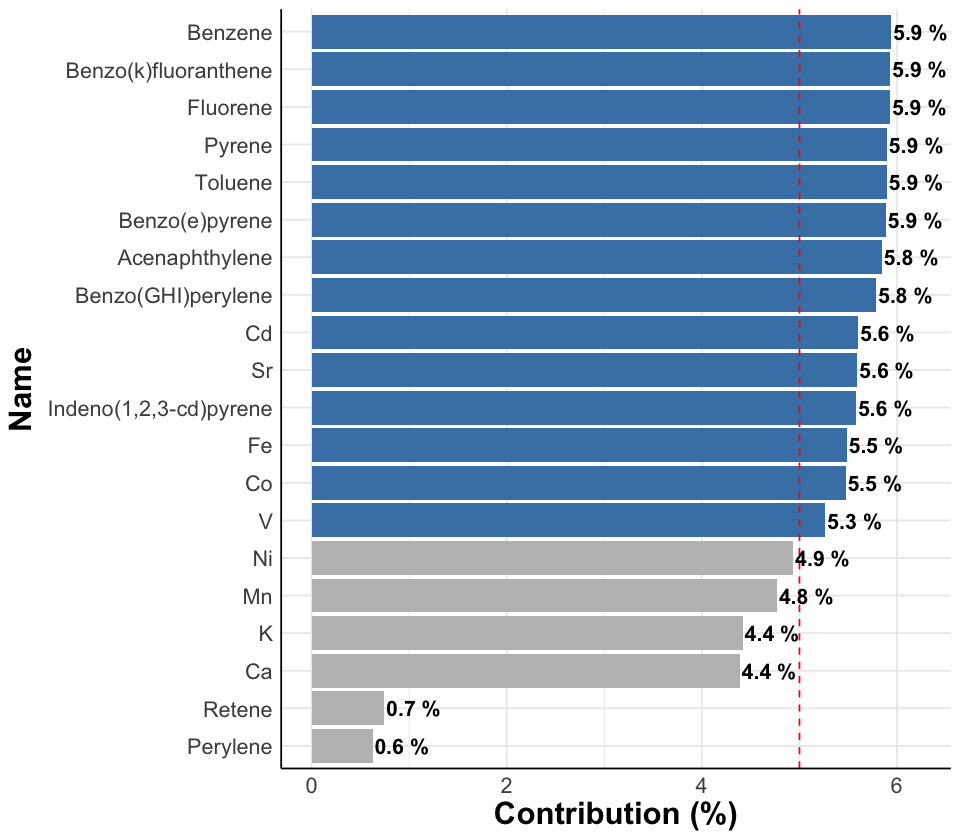

In [24]:
options(repr.plot.width=8, repr.plot.height=7) #changing size
vol_contrib = ggplot(vol_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(vol_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.3, label = paste(round(Contribution, 1), "%")), fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

vol_contrib

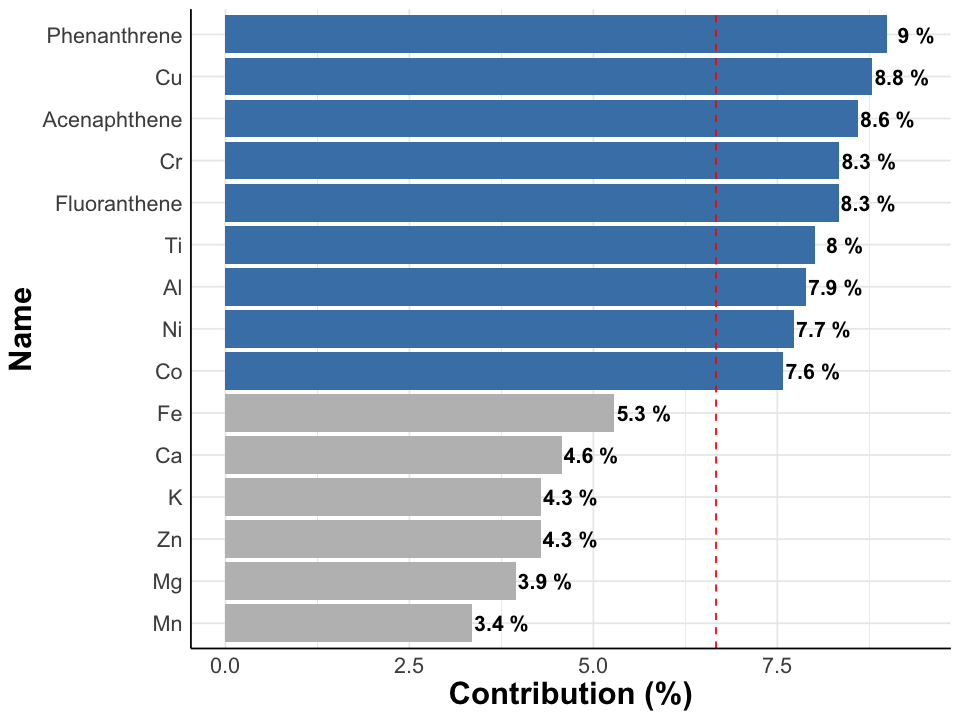

In [25]:
options(repr.plot.width=8, repr.plot.height=6) #changing size
weight_contrib = ggplot(weight_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(weight_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.4, label = paste(round(Contribution, 1), "%")), 
            fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

weight_contrib

In [34]:
# # exporting figures
# ggsave(metal_vol_contrib, 
#        filename = 'metalvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_vol_contrib, 
#        filename = 'pahvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)
# ggsave(voc_vol_contrib, 
#        filename = 'vocvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 10, height = 5)
# ggsave(metal_weight_contrib, 
#        filename = 'metalweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_weight_contrib, 
#        filename = 'pahweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)